In [27]:
## HW02 Code

### Name: Murt Sayeed

#You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
#1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
#2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


#Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135/home).

# import libraries as needed
import operator
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [28]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [29]:
data = pd.read_csv('data.csv')
data

x_i        y_i
0    1.590909   2.846988
1    1.803030   2.959811
2    4.984848  13.041394
3    1.696970   3.971889
4    1.272727   2.454520
..        ...        ...
95   5.090909  11.537465
96  10.500000  10.381492
97   1.484848   2.683212
98   0.636364   1.437600
99   0.848485   0.990251

[100 rows x 2 columns]

In [30]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [31]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
    
    for degree in polynomials:
        poly = PolynomialFeatures(degree)
        xtrain = poly.fit_transform(x)
        linearreg = linear_model.LinearRegression()
        linearreg.fit(xtrain, y)
        y_train_pred = linearreg.predict(xtrain)
        prediction_list.append(y_train_pred)
        error_list.append(mean_squared_error(y, y_train_pred))
   
    # COMPLETED-TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
        
    return prediction_list, error_list
    

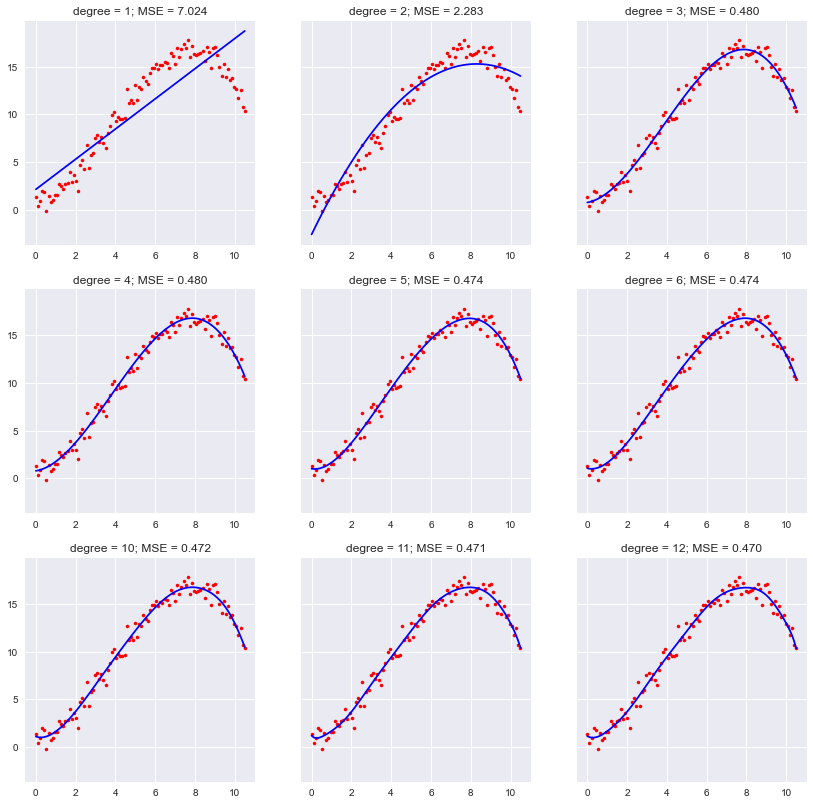

In [32]:
# COMPLETED-TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
degree1 = [1, 2, 3, 4, 5, 6, 10, 11, 12]
prediction_list, error_list = test_polynomials(degree1)
plot_predictions(degree1, prediction_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The plotted results above show that degree 12 is the best model out of the nine given degrees. The polynomial degrees of 1 & 2 are the worest since they don't represent our data correctly compare to other degrees. Afterwards, the degrees 3-12 represent the better MSE values (low error). However, we may want to stop increasing degrees since we run a risk of overfitting. When looking at MSE values on all degrees charts above, we can see that degree 3-12 are within a small range of values (0.48 to 0.47), compare to degrees 1 & 2. Thus, we may want to stop at degree 3 here.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [33]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    step = int(x.size / num_folds)
    
    for i in range(0, x.size, step):
        x_folds.append(x[i:i+step])
        y_folds.append(y[i:i+step])
    
    # COMPLETED-TODO: Complete method to generate partition into folds.
    
    return x_folds, y_folds

In [34]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

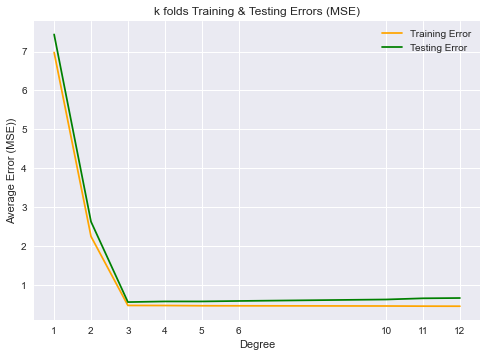

        Training Error (MSE)  Testing Error (MSE)
Degree                                           
1                   6.977641             7.441157
2                   2.245920             2.625608
3                   0.471621             0.558083
4                   0.469909             0.574623
5                   0.463663             0.574580
6                   0.462069             0.586606
10                  0.457199             0.624748
11                  0.453294             0.654943
12                  0.451891             0.662556


In [35]:
# COMPLETED-TODO: Perform 5-fold cross-validation for each polynomial degree.  

final = list()
for degree in degree1:
    train_errors = list()
    test_errors = list()
    for i in range(k):
        x_test = x_folds[0]
        x_folds.remove(x_test)
        x_train = np.concatenate(x_folds, axis=0)

        y_test = y_folds[0]
        y_folds.remove(y_test)
        y_train = np.concatenate(y_folds)

        poly = PolynomialFeatures(degree)
        xs_train = poly.fit_transform(x_train)
        xs_test = poly.fit_transform(x_test)
        linreg = linear_model.LinearRegression()
        linreg.fit(xs_train, y_train)

        y_trained = linreg.predict(xs_train)
        y_pred = linreg.predict(xs_test)

        train_errors.append(mean_squared_error(y_train, y_trained))
        test_errors.append(mean_squared_error(y_test, y_pred))
        x_folds.append(x_test)
        y_folds.append(y_test)

    error_tr = np.mean(train_errors)
    error_te = np.mean(test_errors)
    final.append([degree, error_tr, error_te])
    
# Keep track of average training/test error for each degree

df_final = pd.DataFrame(final, columns = ['Degree', 'Training Error (MSE)', 'Testing Error (MSE)'])
df_final.set_index('Degree',inplace=True)

#Plot results in a single table, properly labeled, and also
plt.plot(degree1, df_final['Training Error (MSE)'], color='orange')
plt.plot(degree1, df_final['Testing Error (MSE)'], color='green')
plt.xlabel('Degree')
plt.ylabel('Average Error (MSE))')
plt.title('k folds Training & Testing Errors (MSE)')
plt.legend(['Training Error','Testing Error'])
plt.xticks(degree1)

plt.show()

#print out the results in some clear tabular format.
print(df_final)

#### 2.3 Discuss the results seen in the plots above

**Discussion:** The above results prove our intuition about training MSE vs testing MSE and the concept of overfitting. As Training data MSE is getting smaller but after the first two degrees, it is steady and not much has changed. For Testing data, the MSE increases back after the first three degrees, meaning degree 3 may be our best degree model to stop at.


### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

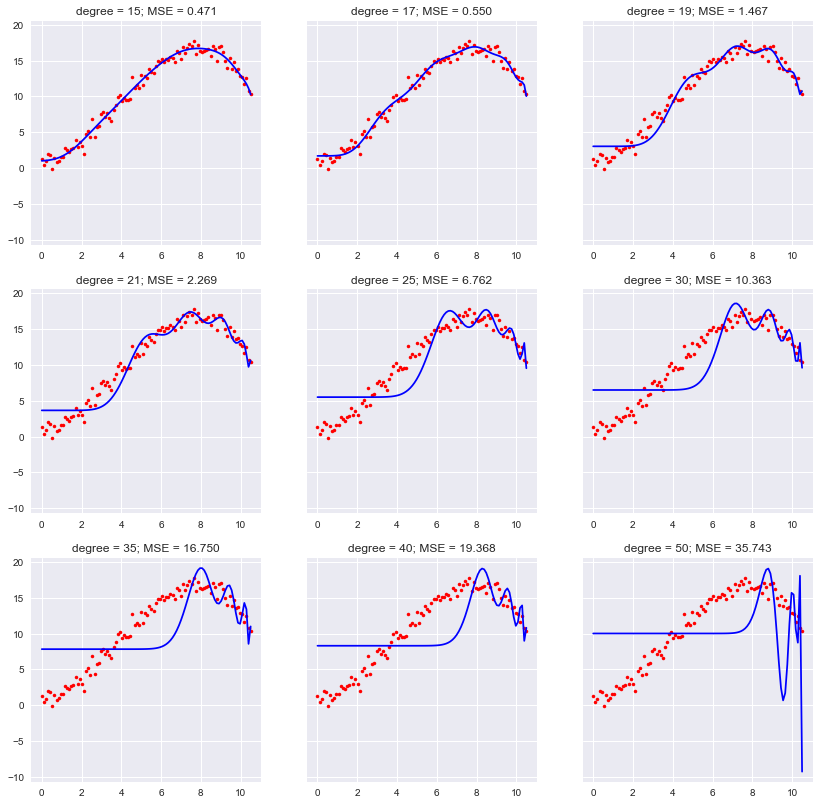

In [36]:
# COMPLETED-TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.
degree2 = [15, 17, 19, 21, 25, 30, 35, 40, 50]
prediction_list, error_list = test_polynomials(degree2)
plot_predictions(degree2, prediction_list, error_list)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The above plotted results show that as we increase the degree of the polynomial, the overfitting is a problem that doesn't help repersent or define our original data correctly. The high MSE is also a problem with increased degrees since its our goal to reduce MSE as much as possible. Thus, the high degrees of polynomila doesn't convey the model will be correct or accurate and we would have to stop somehwere in the middle.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

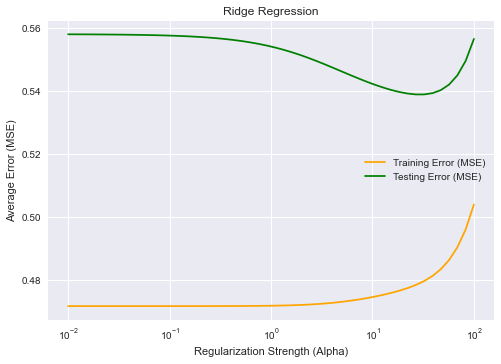

                   Alpha  Training Error (MSE)  Testing Error (MSE)
0                   0.01              0.471621             0.558036
1   0.012067926406393288              0.471621             0.558026
2   0.014563484775012436              0.471621             0.558015
3   0.017575106248547922              0.471621             0.558001
4   0.021209508879201904              0.471621             0.557984
5   0.025595479226995357              0.471621             0.557963
6   0.030888435964774818              0.471621             0.557939
7     0.0372759372031494              0.471621             0.557909
8    0.04498432668969444              0.471621             0.557873
9   0.054286754393238594              0.471621             0.557831
10    0.0655128556859551              0.471621             0.557779
11   0.07906043210907697              0.471622             0.557717
12   0.09540954763499938              0.471622             0.557643
13    0.1151395399326447              0.471623  

In [37]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

alphas = np.logspace(-2, 2, base=10, num=50)
models = list()

pol = PolynomialFeatures(degree=3)

for alpha in np.nditer(alphas):
    ridge = linear_model.Ridge(alpha)
    
    train_errs = list()
    test_errs = list()
    
    for i in range(k):
        x_test = x_folds[0]
        x_folds.remove(x_test)
        x_train = np.concatenate(x_folds, axis=0)

        y_test = y_folds[0]
        y_folds.remove(y_test)
        y_train = np.concatenate(y_folds)

        xs_train = pol.fit_transform(x_train)
        xs_test = pol.fit_transform(x_test)
    
        ridge.fit(xs_train, y_train)
        y_trained = ridge.predict(xs_train)
        y_pred = ridge.predict(xs_test)

        train_errs.append(mean_squared_error(y_train, y_trained))
        test_errs.append(mean_squared_error(y_test, y_pred))
        x_folds.append(x_test)
        y_folds.append(y_test)

    error_tr = np.mean(train_errs)
    error_te = np.mean(test_errs)
    
    models.append([alpha, error_tr, error_te])

models_df = pd.DataFrame(models, columns=['Alpha', 'Training Error (MSE)', 'Testing Error (MSE)'])

plt.plot(alphas, models_df['Training Error (MSE)'], color='orange')
plt.plot(alphas, models_df['Testing Error (MSE)'], color='green')
plt.xlabel('Regularization Strength (Alpha)')
plt.ylabel('Average Error (MSE)')
plt.title('Ridge Regression')
plt.legend(['Training Error (MSE)','Testing Error (MSE)'])
plt.xscale('log')

plt.show()

print(models_df)

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The above plotted results show that we have a range of point (10^1 to 10^2) with lowest point of MSE. This point can be the perfect regularization strength (alpha) that can help us avoid overfitting. It seems that the Training MSE is not affected since it increases slowly but Testing MSE is minimized at a point where Training MSE is one of the lowest if not the lowest.